In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib import cm
import arviz as az
import pymc as pm

# Assignment 1: Toxicity bioassay

## Problem and data

A **bioassay** is biochemical test to estimate the potency of a sample compound. A typical bioassay involves a stimulus (ex. drugs) applied to a subject (ex. animals, tissues, plants). The corresponding response (ex. death) of the subject is thereby triggered and measured (Wikipedia).

The following bioassay taken from Racine et al. (1986) is meant to evaluate the toxicity of a drug on animals. The effect of the drug is evaluated at $N=4$ dose levels. Each dose level $x_i$ is administered to a batch of $n_i$ animals. The number of deaths $y_i$ is the observed response.

| |Dose $x_i$ (log g/ml) | Number of animals $n_i$ | Number of deaths $y_i$ |
| ---|--- | --- | --- |
| 1|-0.86 | 5 | 0 |
| 2|-0.30 | 5 | 1 |
| 3|-0.05 | 5 | 3 |
| 4|0.73  | 5 | 5 |


For instance, the dose level $x_3=-0.05$ has been administered at $n_3=5$ animals. Out of the 5 animals, $y_3=3$ died. <br/>
Note that the dose $x_i$ is measured on a logarithmic scale. Thus, negative concentration levels are present.

We define for convenience (both as math symbols and as Python objects) the vectors $x$, $n$, and $y$ containing the quantities of the corresponding columns.

In [2]:
x = np.array([-0.86, -0.30, -0.05, 0.73]) # dose levels
n = np.array([5., 5., 5., 5.]) # number of subjects per dose level
y = np.array([0, 1, 3, 5]) # number of deaths per dose level

## Modeling assumptions

For the probabilistic model, we make the following assumptions:

1. The outcome of the $n_i$ animals within each group $i$ are *independent*. Each animal in the group has probability $p_i$ of death.

2. The probability of death $p_i$ depends on the dose $x_i$ as follows:
    $$p_i = \rm{sigm}(\alpha + \beta x_i),$$ 
    where 
    \begin{align*}
    \rm{sigm}(z) = \frac{1}{1 + e^{-z}}.
    \end{align*}
3. The prior probability of the parameters 
$\theta = \begin{bmatrix}
\alpha \\
\beta
\end{bmatrix}$
is Gaussian: 
\begin{align}
\alpha &\sim \mathcal{N}(\mu_\alpha, \sigma^2_\alpha), \qquad \mu_\alpha = 0, \sigma_\alpha=2\\
\beta &\sim \mathcal{N}(\mu_\beta, \sigma^2_\beta), \qquad \mu_\beta=10, \sigma_\beta=10.
\end{align}
4. The outcomes in the four groups are independent of each other, given $\theta$.


## 1.1: Probabilistic model

* Derive and comment the full probabilistic model.

\begin{align}
\alpha &\sim \mathcal{N}(0, 2^2)\\
\beta &\sim \mathcal{N}(10, 10^2)\\
\text{per ogni gruppo}&:\\
z_i &= \alpha + \beta x_i && \\
p_i &=  \frac{1}{1 + e^{-z_i}}\\
y_{i} &= \text{Bin}(p_i, n=n_i)
\end{align}

## 1.2: Maximum Likelihood estimation 

* Derive an analytical expression of the likelihood function $\mathcal{L}(\theta) = P(y|\theta)$.
* **GC: serve dire ogni dose i costituisce un'osservazione separata?? **

Assuming $\alpha$ and $\beta$ to be equal for each group, for the i-th group we have:

\begin{align}
P(y_i|\theta) = P(y_i|\alpha, \beta) & = 
\binom{y_i}{n_i} \left\{\frac{1}{1 + e^{-z_i}}\right\}^{y_i}
\left\{1-\frac{1}{1 + e^{-z_i}}\right\}^{n_i-y_i}
\\
& = 
\binom{y_i}{n_i} \left\{\frac{1}{1 + e^{-z_i}}\right\}^{y_i}
\left\{\frac{e^{-z_i}}{1 + e^{-z_i}}\right\}^{n_i-y_i}
\\
& = 
\binom{y_i}{n_i} \left\{\frac{1}{1 + e^{-\alpha - \beta x_i}}\right\}^{y_i}
\left\{\frac{e^{-\alpha - \beta x_i}}{1 + e^{-\alpha - \beta x_i}}\right\}^{n_i-y_i}\\
& \propto
\left\{\frac{1}{1 + e^{-\alpha - \beta x_i}}\right\}^{y_i}
\left\{\frac{e^{-\alpha - \beta x_i}}{1 + e^{-\alpha - \beta x_i}}\right\}^{n_i-y_i}
\end{align}


The full likelihood  factorizes  over the groups as follwows: (I guess we cannot  drop the binomial coefficients).
\begin{align}
P(y|\theta) = \prod_i P(y_i|\alpha, \beta) & = 
\prod_i \binom{y_i}{n_i} \left\{\frac{1}{1 + e^{-\alpha - \beta x_i}}\right\}^{y_i}
\left\{\frac{e^{-\alpha - \beta x_i}}{1 + e^{-\alpha - \beta x_i}}\right\}^{n_i-y_i}\\
\end{align}




* Write a Python function corresponding to the likelihood function $\mathcal{L}(\theta)$. Ignore multiplicative factors which do not depend on $\theta$.

** mi sembra che i coefficienti binomiali non possano essere ignorati **

In [3]:
import math 

def sigmoid(z):
    return 1/(1 + np.exp(-z)) 

#GC: i think the likelihood should depend not only on theta, but also on the data (x, y and n)
# As we have different groups,  n and y are vectors.

#ps: what is pass??
#we need passing parameter theta
#def lik(alpha, beta, n, y):
def lik(theta):
    alpha = theta[0]
    beta = theta[1]
    n_groups = len(x)
    lik = 1
    z = alpha + beta * x
    for i in range (n_groups):
        comb = math.comb( int(n[i]), int(y[i]))
        lik = lik * comb * (sigmoid(z[i])**y[i]) *  (1-sigmoid(z[i]))**(n[i]-y[i])
    return (lik)

In [4]:
# a stepsize of 0.1 might be enough

a = np.arange(-4, 8, 0.1)  
b = np.arange(-10, 40, 0.1)
lik_ab = np.zeros([len(a), len(b)])
for i, current_a in enumerate(a):
    for j, current_b in enumerate(b):
        lik_ab[i,j] = lik ([current_a, current_b])

np.savetxt("lik.csv", lik_ab, delimiter=",")

In [5]:
#finding the maximum..
ind = np.unravel_index(np.argmax(lik_ab, axis=None), lik_ab.shape) 

#stampa le coordinate del massimo
a_max = a[ind[0]]
b_max = b[ind[1]]
print("coordinates of the max : " +  str(a_max) + " , " + str(b_max))
print("max lik value: " + str(lik_ab[ind]))

coordinates of the max : 0.8000000000000043 , 7.5999999999999375
max lik value: 0.1375900685018062


* Visualize the likelihood function in 2D and comment the obtained figure. 

   Hints:
    * you may use the `pcolormesh` function of `matplotlib`
    * appropriate ranges for $\alpha$ and $\beta$ are $[-4, 8]$ and $[-10, 40]$, respectively
    * an appropriate step size for both $\alpha$ and $\beta$ is 0.01

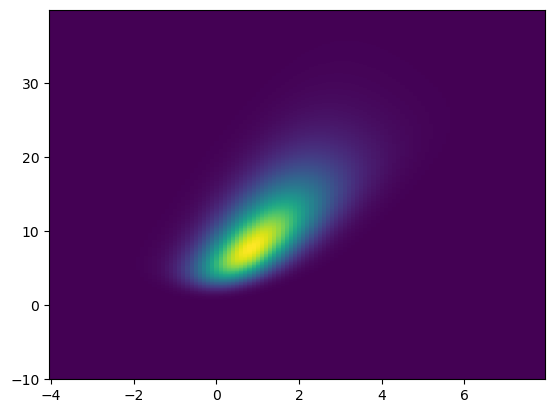

In [6]:
#strangely I hat to invert the matrix (googling about how to do it)
#I find matshow to be more convenient, althout in that case there are no proper labels for axis
#however I had to set the stepsize to 1 for both variables, with 0.01 the figure would look flat
fig, ax = plt.subplots()
ax.pcolormesh(a, b, lik_ab.T);

* Derive an analytical expression of the log-likelihood function $\ell(\theta)$. 

\begin{align}
& \text{log } \left(
\prod_i \binom{y_i}{n_i} \left\{\frac{1}{1 + e^{-\alpha - \beta x_i}}\right\}^{y_i}
\left\{\frac{e^{-\alpha - \beta x_i}}{1 + e^{-\alpha - \beta x_i}}\right\}^{n_i-y_i}
\right)
\\
= &  
\sum_i    \binom{y_i}{n_i} +
y_i \text{ log } \left(
\frac{1}{1 + e^{-\alpha - \beta x_i}} \right) + 
(n_i-y_i) \text{ log }
\left( \frac{e^{-\alpha - \beta x_i}}{1 + e^{-\alpha - \beta x_i}}\right)\\
= &  
\sum_i    \binom{y_i}{n_i} -
y_i \text{ log } \left(
1 + e^{-\alpha - \beta x_i} \right) + 
(n_i-y_i) \text{ log }
\left( \frac{e^{-\alpha - \beta x_i}}{1 + e^{-\alpha - \beta x_i}}\right)
\end{align}

* Write a Python function corresponding to the log-likelihood function $\ell(\theta)$, possibly up to an additive factor not depending on $\theta$. 

In [7]:
#i let the log-likelihood  depend not only on theta, but also on the data (y and n)
#however later it cannot be optimized, so it has to depend only on alpha and beta
#here we can drop the binomial coefficient

#def log_lik(alpha, beta, n, y) 
#def log_lik( [alpha, beta] ) - optimize requires a vector x


def log_lik( theta ):
    groups  = len(n)
    log_lik = 0 
    alpha   = theta[0]
    beta    = theta[1]
    for i  in range(groups):
        e_ab = np.exp( - alpha - beta * x[i])
        log_lik = log_lik - y[i] * np.log(1 + e_ab) + (n[i] - y[i]) * np.log(e_ab / (1 + e_ab))
    return (log_lik)
    

* Visualize the log-likelihood function in 2D and comment the obtained figure. 

In [8]:
#also here, I needed increasing the stepsize to 1 to see something.
a = np.arange(-4, 8, 1)  
b = np.arange(-10, 40, 1)
log_lik_ab = np.zeros([len(a), len(b)])
for i, current_a in enumerate(a):
    for j, current_b in enumerate(b):
        log_lik_ab[i,j] = log_lik ([current_a, current_b])

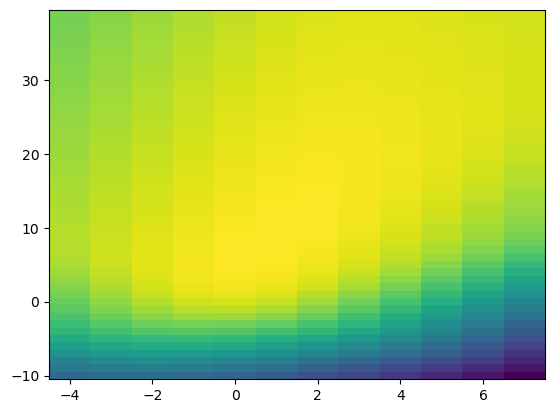

In [9]:
#plt.matshow(log_lik_ab);
fig, ax = plt.subplots()
ax.pcolormesh(a, b, log_lik_ab.T);

* Compute the maximum likelihood estimate $\alpha^{\rm ml}, \beta^{\rm ml}$ of the parameters $\alpha, \beta$ through numerical optimizations. 

    Hints:
     * You may use the Python function `scipy.optimize.minimize`. 
     * You may look at the figures above to define a good starting point for optimization 
     * You may either minimize the likelihood or the log-likelihood. What is your choice?

* Visualize the likelihood function in 2D together with the ML estimate. Comment the obtained figure. 

In [10]:
# minimize the log-lik
# we need a function returning -1*loglik, to minimize it
def m_log_lik( theta ):
    ll = log_lik (theta)
    return (-1 * ll)

def m_lik( theta ):
    l = lik (theta)
    return (-1 * l)


In [11]:
# minimize the log-lik
# we need a function returning -1*loglik, to minimize it

from scipy.optimize import minimize
a0 = 10
b0 = 10

res_loglik = minimize(m_log_lik, [a0, b0]);
print(res_loglik)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 5.894441638972409
        x: [ 8.466e-01  7.749e+00]
      nit: 11
      jac: [ 7.451e-06 -9.537e-07]
 hess_inv: [[ 9.843e-01  3.477e+00]
            [ 3.477e+00  2.361e+01]]
     nfev: 39
     njev: 13


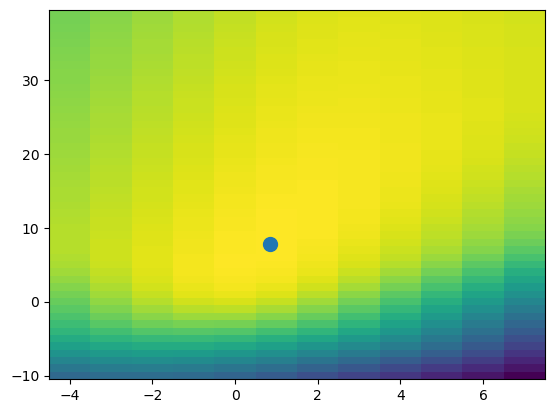

In [12]:
#plt.matshow(log_lik_ab);
fig, ax = plt.subplots()
ax.pcolormesh(a, b, log_lik_ab.T);
x_opt = res_loglik.x[0]
y_opt = res_loglik.x[1]
plt.plot(x_opt, y_opt, marker="o", markersize=10);

In [13]:
# minimize the lik
# does not move from the initialization if the initialization is far from the maximum, 
#as the function is flat in 0: jacobian is 0
res_lik = minimize(m_lik, [a0, b0])
print(res_lik)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -5.838426723803972e-23
        x: [ 1.000e+01  1.000e+01]
      nit: 0
      jac: [ 5.842e-22 -2.772e-22]
 hess_inv: [[1 0]
            [0 1]]
     nfev: 3
     njev: 1


## 1.2: Maximum A Posteriori estimation

* Derive an analytical expression of the posterior $f(\theta | y)$, up to a multiplicative factor not depending on $\theta$. 

Hint: exploit the already-obtained likelihood and the known functional form of the Gaussian pdf.

\begin{align}
f(\theta|y) & \propto f(\theta) f(D|\theta)= f(\alpha) f(\beta) f(D|\theta) \\
& = \prod_i \binom{y_i}{n_i} \left\{\frac{1}{1 + e^{-\alpha - \beta x_i}}\right\}^{y_i}
\left\{\frac{e^{-\alpha - \beta x_i}}{1 + e^{-\alpha - \beta x_i}}\right\}^{n_i-y_i}
e^{-\frac{1}{2}\left(\frac{a - \mu_a}{\sigma_a}\right)^2}
e^{-\frac{1}{2}\left(\frac{b - \mu_a}{\sigma_b}\right)^2}\\
& = \prod_i \binom{y_i}{n_i} \left\{\frac{1}{1 + e^{-\alpha - \beta x_i}}\right\}^{y_i}
\left\{\frac{e^{-\alpha - \beta x_i}}{1 + e^{-\alpha - \beta x_i}}\right\}^{n_i-y_i}
e^{-\frac{1}{2}\left(\frac{a}{2}\right)^2}
e^{-\frac{1}{2}\left(\frac{b - 10}{2}\right)^2}
\end{align}

* Derive an analytical expression of the log-posterior $\log f(\theta | y)$, up to an additive factor not depending on $\theta$.

\begin{align}
\sum_i    \binom{y_i}{n_i} -
y_i \text{ log } \left(
1 + e^{-\alpha - \beta x_i} \right) + 
(n_i-y_i) \text{ log }
\left( \frac{e^{-\alpha - \beta x_i}}{1 + e^{-\alpha - \beta x_i}}\right) -
\frac{1}{2} \frac{a^2}{4} -
\frac{1}{2} \frac{(b-10)^2}{4} = \\
\sum_i    \binom{y_i}{n_i} -
y_i \text{ log } \left(
1 + e^{-\alpha - \beta x_i} \right) + 
(n_i-y_i) \text{ log }
\left( \frac{e^{-\alpha - \beta x_i}}{1 + e^{-\alpha - \beta x_i}}\right) -
\frac{a^2}{8} - \frac{(b-10)^2}{8}
\end{align}

* Write the unnormalized posterior and log-posterior (up to a multiplicative/additive factor, respectively) as Python functions.

In [14]:
def log_post( theta ):
    groups  = len(n)
    alpha   = theta[0]
    beta    = theta[1]
    log_post = -alpha**2/8 #prior on alpha
    log_post = -(beta - 10)**2/8 #prior on beta
    for i  in range(groups):
        e_ab = np.exp( - alpha - beta * x[i])
        log_post = log_post - y[i] * np.log(1 + e_ab) + (n[i] - y[i]) * np.log(e_ab / (1 + e_ab))
    return (log_post)
    

* Compute the maximum a posteriore estimate $\alpha^{\rm MAP}, \beta^{\rm MAP}$.

In [15]:
from scipy.optimize import minimize
a0 = 10
b0 = 10

def m_log_post ( theta ):
    lp = log_post(theta)
    return ( -1 * lp)
    

res_post = minimize(m_log_post, [a0, b0]);
print(res_post)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 5.974202934499842
        x: [ 1.133e+00  9.733e+00]
      nit: 12
      jac: [ 8.345e-07 -5.960e-08]
 hess_inv: [[ 6.243e-01  4.793e-01]
            [ 4.793e-01  3.575e+00]]
     nfev: 39
     njev: 13


* Visualize the MAP estimate together with the unnormalized posterior in 2D. Comment the results.

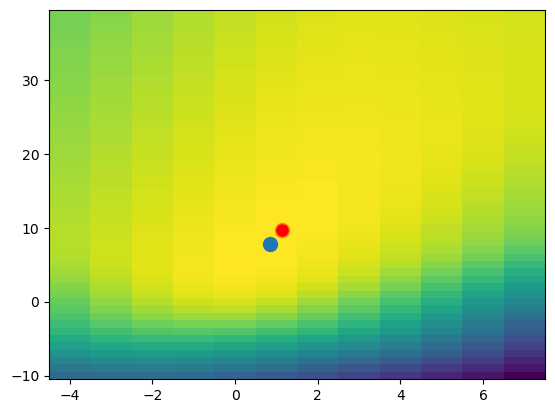

In [16]:
#plt.matshow(log_lik_ab);
fig, ax = plt.subplots()
ax.pcolormesh(a, b, log_lik_ab.T);
x_opt_post = res_post.x[0]
y_opt_post = res_post.x[1]
plt.plot(x_opt, y_opt, marker="o", markersize=10);
plt.plot(x_opt_post, y_opt_post, marker="o", markersize=10, markerfacecolor="red");

## 1.3 Brute-force posterior estimation

* Compute a gridding approximation of the *normalized* posterior, with the correct normalization constant. Explain the passages.

* Using the grid-based approximation of the posterior, compute the posterior mean of $\alpha$ and $\beta$.

## 1.4 Monte-carlo posterior estimation

* Obtain a sample-based approximation of the posterior $f(\theta | y)$ by implementing the Metropolis algorithm from scratch.

* Compare the Metropolis samples with the gridding-based approximation of the posterior distribution $f(\theta | y)$ and comment the result.

* Obtain a sample-based approximation of the posterior $f(\theta | y)$ using pymc3.

* Comment the results obtained with pymc3 and compare them with previous results (gridding and Metropolis from scratch).